In [88]:
#Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, linear
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

import optuna

In [23]:
train_data_path = os.path.join('..', 'data','raw','train.csv')
test_data_path = os.path.join('..', 'data','raw','test.csv')
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [3]:
print(train_data.shape)
train_data.head()

(188533, 13)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
train_data.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


In [5]:
train_data.dtypes

id               int64
brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object

In [6]:
nan_counts = train_data.isna().sum()
nan_table = pd.DataFrame(nan_counts, columns= ['nan_total'])
nan_table

,nan_total
id,0
brand,0
model,0
model_year,0
milage,0
fuel_type,5083
engine,0
transmission,0
ext_col,0
int_col,0


There is a lot of categorical variables so we have to decide what to do with them, the first thing it occurs to me is see how many categories does have every categorical variable. Also we have missing values.

# Handling missing values

## Fuel type 
I have an hypotesis: The most common type of fuel type is gasoline so the most probable thing is that this cars that do not have a fuel type assigned they use gasoline as a fuel type. 

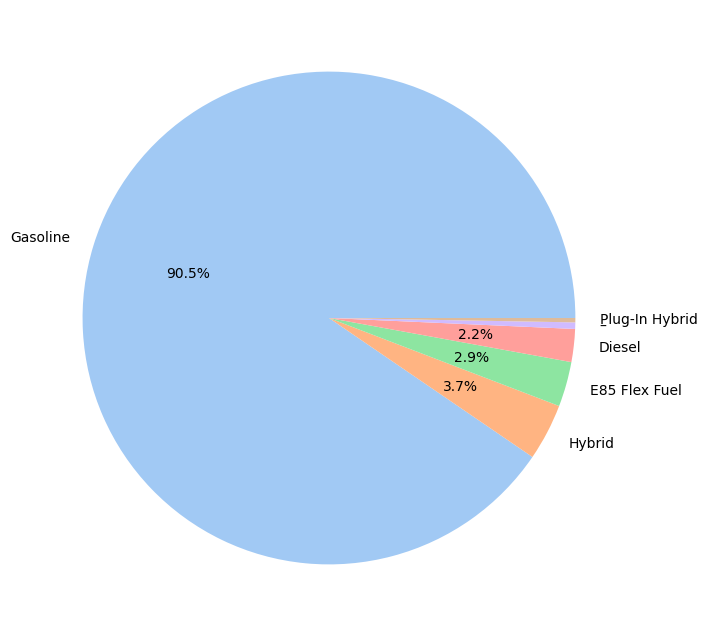

In [7]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        if pct > 2:  
            return f'{pct:.1f}%'
        else:
            return ''  
    return my_format

fuel_type_vc = train_data['fuel_type'].value_counts()[:-1]
colors = sns.color_palette('pastel')[0:len(fuel_type_vc)]
plt.figure(figsize= (10,8))
plt.pie(fuel_type_vc, labeldistance= 1.1,labels= fuel_type_vc.index, colors= colors, autopct= autopct_format(fuel_type_vc))
plt.show()

Keeping this graph in mind we already know what to do with the missing values, we are going to imput it to Gasoline. The question is how do we procces this unbalances column, i can think it 3 ways:
1. Eliminate the column
2. Binarized (Gasoline or other)
3. Normal One Hot Encoding
   
To decide lets make another graph.

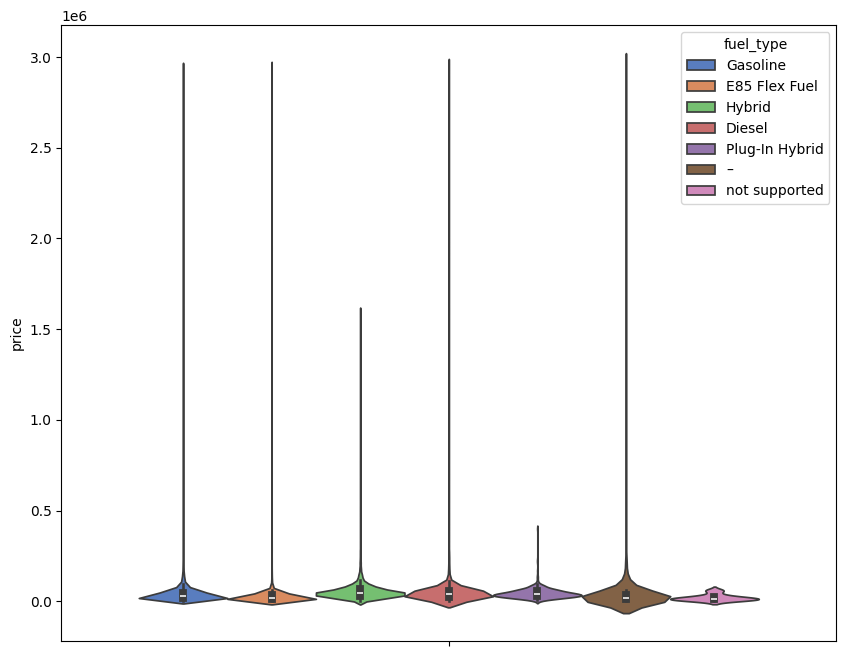

In [8]:
plt.figure(figsize=(10,8))
sns.violinplot(hue= 'fuel_type', y= 'price', data= train_data, palette= 'muted')
plt.show()

What i see here is that there is little difference of the price of the vehicle and its fuel type i think the best for now is eliminating this column but if we need more complexity for the model we can add it with a binary approach.

## Accident

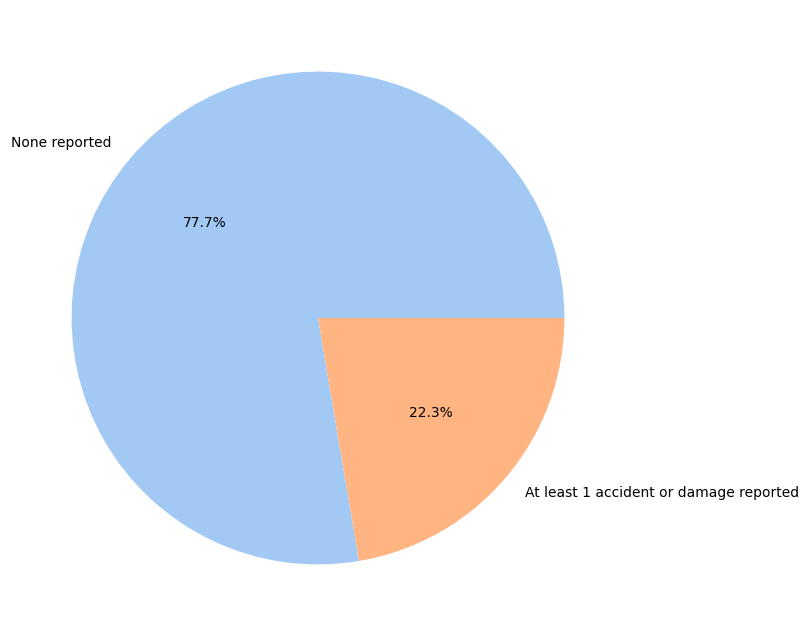

In [9]:
accident_vc = train_data['accident'].value_counts()
plt.figure(figsize= (10,8))
plt.pie(accident_vc, labeldistance= 1.1,labels= accident_vc.index, colors= colors, autopct= '%1.1f%%')
plt.show()

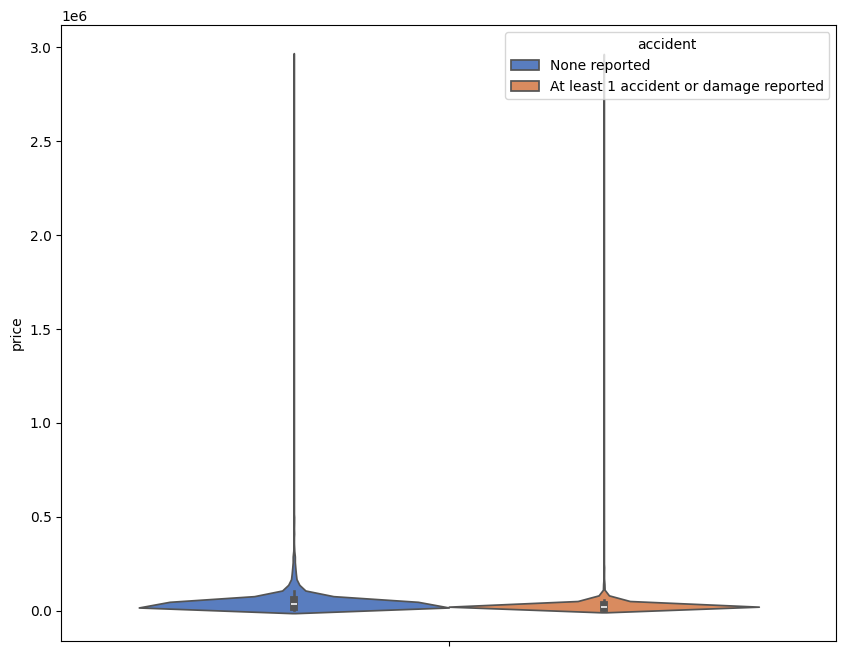

In [10]:
plt.figure(figsize=(10,8))
sns.violinplot(hue= 'accident', y= 'price', data= train_data, palette= 'muted')
plt.show()

Here we will binarize and also for missing data we will use none reported.

## Clean Title

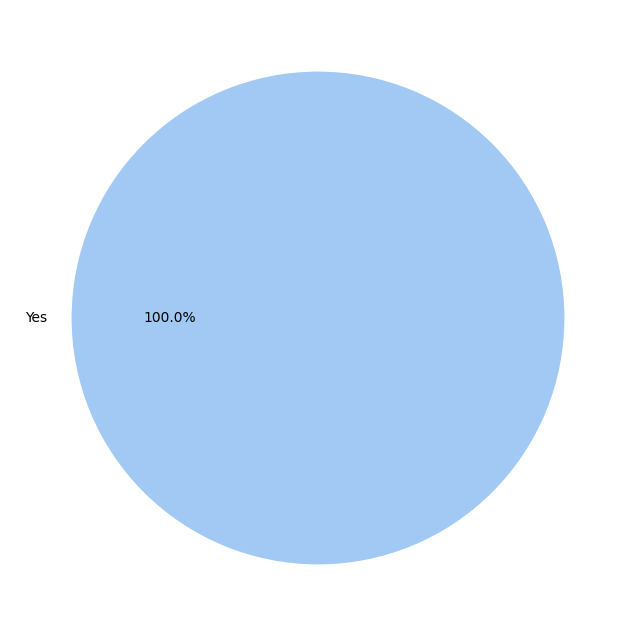

In [11]:
clena_title_vc = train_data['clean_title'].value_counts()
plt.figure(figsize= (10,8))
plt.pie(clena_title_vc, labeldistance= 1.1,labels= clena_title_vc.index, colors= colors, autopct= '%1.1f%%')
plt.show()

Here we can see that the null or missing values from the clean title column refers to cars that doesnot have clean titles 

## Other values

In [12]:
categorical_vars = ['brand', 'model', 'engine', 'transmission', 'ext_col', 'int_col'] #Discart model year we can just normalize

In [13]:
train_data[categorical_vars].nunique()

brand             57
model           1897
engine          1117
transmission      52
ext_col          319
int_col          156
dtype: int64

High cardinality problems

In [14]:
threshold = 0.03 #adjust
for col in categorical_vars:
    frequency = train_data[col].value_counts(normalize= True)
    rare_categories = frequency[frequency < threshold].index
    train_data[col] = train_data[col].apply(lambda x: 'Other' if x in rare_categories else x)

In [15]:
train_data[categorical_vars].nunique()

brand           11
model            1
engine           1
transmission    10
ext_col          7
int_col          5
dtype: int64

In [16]:
train_data.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

## Creata data pre-proccesing function

In [24]:
def preproccess(df, threshold=0.03):
    df = df.copy()
    drop_columns = ['model', 'engine', 'id']
    
    hot_encoding_columns = ['brand', 'transmission', 'ext_col', 'int_col']
    
    categorical_vars = hot_encoding_columns + ['fuel_type', 'accident', 'clean_title']
    
    df['fuel_type'] = df['fuel_type'].apply(lambda x: 1 if x == 'Gasoline' else 0)
    df['accident'] = df['accident'].apply(lambda x: 1 if x == 'At least 1 accident or damage reported' else 0)
    df['clean_title'] = df['clean_title'].apply(lambda x: 1 if x == 'Yes' else 0)
    
    df.drop(drop_columns, axis=1, inplace=True)
    
    for col in hot_encoding_columns:
        frequency = df[col].value_counts(normalize=True)
        rare_categories = frequency[frequency < threshold].index
        df[col] = df[col].apply(lambda x: 'Other' if x in rare_categories else x)
    

    df = pd.get_dummies(df, columns=hot_encoding_columns, drop_first=True)
    
    return df

In [72]:
df = preproccess(train_data)
test_df = preproccess(test_data)
test_df.head()

,model_year,milage,fuel_type,accident,clean_title,brand_BMW,brand_Chevrolet,brand_Ford,brand_Jeep,brand_Land,...,ext_col_Blue,ext_col_Gray,ext_col_Other,ext_col_Red,ext_col_Silver,ext_col_White,int_col_Black,int_col_Brown,int_col_Gray,int_col_Other
0,2015,98000,1,0,1,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1,2020,9142,0,0,1,False,False,False,False,True,...,False,False,False,False,True,False,True,False,False,False
2,2022,28121,1,0,0,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True
3,2016,61258,1,0,0,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
4,2018,59000,1,0,1,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False


In [58]:
features = df.columns[df.columns != 'price']
target =['price']
mmscaler = MinMaxScaler()
rb_scaler = RobustScaler()
df_scaled = mmscaler.fit_transform(df[features])
target_scaled = rb_scaler.fit_transform(df[target])
X_train, X_val, y_train, y_val = train_test_split(df_scaled, target_scaled, test_size= 0.07, shuffle= True, random_state= 3004)


## Model

In [61]:
#def objective(trial):
 #   learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log= True )
  #  dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
   # l2_lambda = trial.suggest_float('l2_lambda', 1e-5, 1e-2, log= True)

    #model = tf.keras.models.Sequential([
     #   InputLayer(shape=(34,)),  
      #  Dense(64, activation= relu, 
       #                       kernel_regularizer=regularizers.l2(l2_lambda)),
        #Dropout(dropout_rate),
        
        #Dense(64, activation=relu, 
         #                     kernel_regularizer=regularizers.l2(l2_lambda)),
        #Dropout(dropout_rate),
        #Dense(32, activation=relu, 
         #                     kernel_regularizer=regularizers.l2(l2_lambda)),
        #Dropout(dropout_rate),

        #Dense(16, activation=relu, 
         #                     kernel_regularizer=regularizers.l2(l2_lambda)),
        #Dense(1, activation='linear')  
    #])

   
    #model.compile(optimizer=Adam(learning_rate=learning_rate),
     #             loss='mse',  # Mean Squared Error
      #            metrics=['mae'])  # Mean Absolute Error

    #early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    #history = model.fit(X_train, y_train,
     #                   validation_data=(X_val, y_val),
      #                  epochs=100,
       #                 batch_size=32,
        #                callbacks=[early_stopping],
         #               verbose=0)

    #val_loss = model.evaluate(X_val, y_val, verbose=0)
    #return val_loss[0]


#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=50)

#print(f"Best parameters: {study.best_params}")

[I 2024-09-10 19:58:24,028] A new study created in memory with name: no-name-a76544d8-fbaf-4d95-9358-38559ed03309
[I 2024-09-10 19:58:44,370] Trial 0 finished with value: 3.3975329399108887 and parameters: {'learning_rate': 0.0017103815134707412, 'dropout_rate': 0.4350647991455672, 'l2_lambda': 0.00011276018217292319}. Best is trial 0 with value: 3.3975329399108887.
[I 2024-09-10 19:59:55,402] Trial 1 finished with value: 3.3277621269226074 and parameters: {'learning_rate': 0.000126014447126749, 'dropout_rate': 0.31837220936511085, 'l2_lambda': 3.761604469422678e-05}. Best is trial 1 with value: 3.3277621269226074.
[I 2024-09-10 20:00:29,451] Trial 2 finished with value: 3.3974950313568115 and parameters: {'learning_rate': 0.0006368748676900512, 'dropout_rate': 0.4944365778524541, 'l2_lambda': 0.00026150476024061327}. Best is trial 1 with value: 3.3277621269226074.
[I 2024-09-10 20:01:28,126] Trial 3 finished with value: 3.319149971008301 and parameters: {'learning_rate': 7.00155011810

Best parameters: {'learning_rate': 4.2880817985314055e-05, 'dropout_rate': 0.12711730758599005, 'l2_lambda': 1.4953417407400252e-05}


In [67]:
model = tf.keras.models.Sequential([
        InputLayer(shape=(34,)),  
        Dense(32, activation= relu, 
                              kernel_regularizer=regularizers.l2(0)),
        Dense(16, activation=relu, 
                              kernel_regularizer=regularizers.l2(0)),
        Dense(8, activation= relu, 
                              kernel_regularizer=regularizers.l2(0)),
        Dense(4, activation=relu, 
                              kernel_regularizer=regularizers.l2(0)),
                Dense(1, activation=linear)  
    ])

   
model.compile(optimizer=Adam(learning_rate=4.2880817985314055e-04),
                  loss='mse',  
                  metrics=['mae'])  

    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  
model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=300,
                        batch_size=32,
                        callbacks=[early_stopping])

Epoch 1/100
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 2s 257us/step - loss: 5.3772 - mae: 0.7292 - val_loss: 3.3877 - val_mae: 0.6527
Epoch 2/100
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step - loss: 4.8627 - mae: 0.6495 - val_loss: 3.3712 - val_mae: 0.6399
Epoch 3/100
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 1s 244us/step - loss: 4.9943 - mae: 0.6502 - val_loss: 3.3643 - val_mae: 0.5985
Epoch 4/100
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 1s 246us/step - loss: 5.1931 - mae: 0.6557 - val_loss: 3.3770 - val_mae: 0.7030
Epoch 5/100
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step - loss: 4.7938 - mae: 0.6439 - val_loss: 3.3341 - val_mae: 0.6454
Epoch 6/100
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step - loss: 5.6326 - mae: 0.6512 - val_loss: 3.3520 - val_mae: 0.6678
Epoch 7/100
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 1s 244us/step - loss: 5.3362 - mae: 0.6505 - val_loss: 3.3400 - val_mae: 0.6591
Epoch 8/100
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step - loss: 4.7256 - mae: 0.6424 - val_loss: 3.3334 - val_mae: 0.6057
Epoch 9/100
5480

In [68]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
val_loss[0]

3.312835931777954

## Fast lightgbm experiment 

In [87]:
import lightgbm as lgb

In [102]:
#def objective(trial):
    
 #   param = {
  #      'objective': 'regression',
   #     'metric': 'rmse',
    #    'boosting_type': 'gbdt',
     #   'num_leaves': trial.suggest_int('num_leaves', 20, 300),
      #  'max_depth': trial.suggest_int('max_depth', 3, 12),
       # 'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log= True),
        #'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        #'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10, log= True),
        #'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        #'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10, log= True),
        #'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10, log= True),
        #'early_stopping_rounds': 100
    #}

    #train_data = lgb.Dataset(X_train, label=y_train)
    #valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    
    #gbm = lgb.train(param, train_data, valid_sets=[valid_data])

    
    #preds = gbm.predict(X_val)
    #rmse = mean_squared_error(y_val, preds, squared=False)

    #return rmse

#study = optuna.create_study(direction='minimize')  
#study.optimize(objective, n_trials=100)  

#print("Best hyperparameters: ", study.best_params)

#print("Best RMSE: ", study.best_value)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 17)

In [93]:
train_data = lgb.Dataset(X_train, label=y_train)
param =  {'num_leaves': 41, 'max_depth': 11, 'learning_rate': 0.07168594387102047, 'n_estimators': 859, 'min_child_weight': 0.037781836059008124, 'subsample': 0.8011142327220467, 'colsample_bytree': 0.6568535791049425, 'reg_alpha': 0.035463141758411754, 'reg_lambda': 0.0941159758083554}
gbm = lgb.train(param, train_data)

/Users/rospel/anaconda3/envs/Project1/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/rospel/anaconda3/envs/Project1/lib/python3.11/site-packages/lightgbm/basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 175335, number of used features: 34
[LightGBM] [Info] Start training from score 0.397578


## Predictions

In [97]:
preds = gbm.predict(mmscaler.transform(test_df))
t_preds = rb_scaler.inverse_transform(preds.reshape(-1,1))
t_preds = t_preds.reshape(-1)

In [98]:
submit_df = pd.DataFrame(data= {'id': test_data['id'], 'price': t_preds})

In [99]:
submit_df.to_csv('../data/submission.csv', index= False)

In [100]:
submit_df.shape

(125690, 2)